In [ ]:
!git clone https://github.com/WouterBant/GEVit-DL2-Project.git

In [3]:
%cd GEVit-DL2-Project/post_hoc_equivariance

[Errno 2] No such file or directory: 'GEVit-DL2-Project/post_hoc_equivariance'
/home/wouter/dl2/GEVit-DL2-Project/post_hoc_equivariance


In [85]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install einops
!pip install wandb

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvtf
import torchvision.transforms.functional as TF

import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from datasets import MNIST_rot, PCam
from train_vit import VisionTransformer

from helpers import timeit

In [32]:
rotmnist = False  # TODO change this if needed

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using CUDA
    torch.backends.cudnn.deterministic = True  # if using CUDA
    torch.backends.cudnn.benchmark = False  # if using CUDA, may improve performance but can lead to non-reproducible results

def get_non_equivariant_vit(rotmnist_model):
    if rotmnist_model:
        model = VisionTransformer(embed_dim=64,
                                hidden_dim=512,
                                num_heads=4,
                                num_layers=6,
                                patch_size=4,
                                num_channels=1,
                                num_patches=49,
                                num_classes=10,
                                dropout=0.1).to(device)
        model_path = "../saved/results/model2.pt"
        print(model.load_state_dict(torch.load(model_path, map_location=device), strict=False))
    else:  # pcam
        model = VisionTransformer(embed_dim=64,
                            hidden_dim=512,
                            num_heads=4,
                            num_layers=6,
                            patch_size=6,
                            num_channels=3,
                            num_patches=256,
                            num_classes=2,
                            dropout=0.1).to(device)
        model_path = "../saved/results/modelpcam.pt"
        print(model.load_state_dict(torch.load(model_path, map_location=device), strict=False))
    return model

model = get_non_equivariant_vit(rotmnist)

<All keys matched successfully>


In [96]:
if rotmnist:
    data_mean = (0.1307,)
    data_stddev = (0.3081,)
    transform_train = tvtf.Compose([
        tvtf.RandomRotation(degrees=(-180, 180)),  # random rotation
        tvtf.ToTensor(),
        tvtf.Normalize(data_mean, data_stddev)
    ])
    transform_test = tvtf.Compose(
        [
            tvtf.ToTensor(),
            tvtf.Normalize(data_mean, data_stddev),
        ]
    )

    train_set = MNIST_rot(root="../data", stage="train", download=True, transform=transform_train, data_fraction=1, only_3_and_8=False)
    validation_set = MNIST_rot(root="../data", stage="validation", download=True, transform=transform_test, data_fraction=1, only_3_and_8=False)
    test_set = MNIST_rot(root="../data", stage="test", download=True, transform=transform_test, data_fraction=1, only_3_and_8=False)
else:
    data_mean = (0.701, 0.538, 0.692)
    data_stddev = (0.235, 0.277, 0.213)
    transform_train = tvtf.Compose([
        tvtf.RandomRotation(degrees=(-180, 180)),  # random rotation
        tvtf.RandomHorizontalFlip(),  # random horizontal flip with a probability of 0.5
        tvtf.RandomVerticalFlip(),
        tvtf.ToTensor(),
        tvtf.Normalize(data_mean, data_stddev)
    ])
    transform_test = tvtf.Compose(
        [
            tvtf.ToTensor(),
            # tvtf.Normalize(data_mean, data_stddev),
        ]
    )

    train_set = PCam(root="../data", train=True, download=True, transform=transform_train)
    validation_set = PCam(root="../data", train=False, valid=True, download=True, transform=transform_test, data_fraction=0.005)
    test_set = PCam(root="../data", train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
)
val_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    num_workers=4,
)
img_loader = torch.utils.data.DataLoader(  # single element for visualization purposes
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

Total length of the dataset: 32768
Reduced length of the dataset: 163


In [77]:
def train(model, train_loader, n_epochs=5, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = evaluate(model)
    print(f"Starting validaitons accuracy: {best_val_acc}")
    best_model_state = None

    for epoch in tqdm(range(n_epochs)):
        epoch_losses = []
        for images, targets in train_loader:
            images = images.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        # validate and store best model state
        val_acc = evaluate(model)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())

        # log epoch loss
        print(f"Epoch {epoch+1}: loss {sum(epoch_losses)/len(epoch_losses):.4f}, validation accuracy {val_acc}")

    # Load best model state into the original model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model.to(device)

def evaluate(model):
    model.eval()
    correct = total = 0
    with torch.no_grad():  # disable gradient calculation during inference
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # move inputs and labels to device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    return test_acc

def test(model):
    model.eval()
    correct = total = 0
    with torch.no_grad():  # disable gradient calculation during inference
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # move inputs and labels to device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    return test_acc

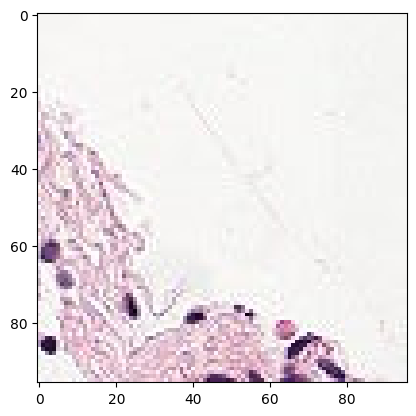

In [58]:
data = iter(img_loader)
image, target = next(data)
plt.imshow(image.squeeze() if rotmnist else image.squeeze().transpose(0, 2), cmap="gray")
plt.show()

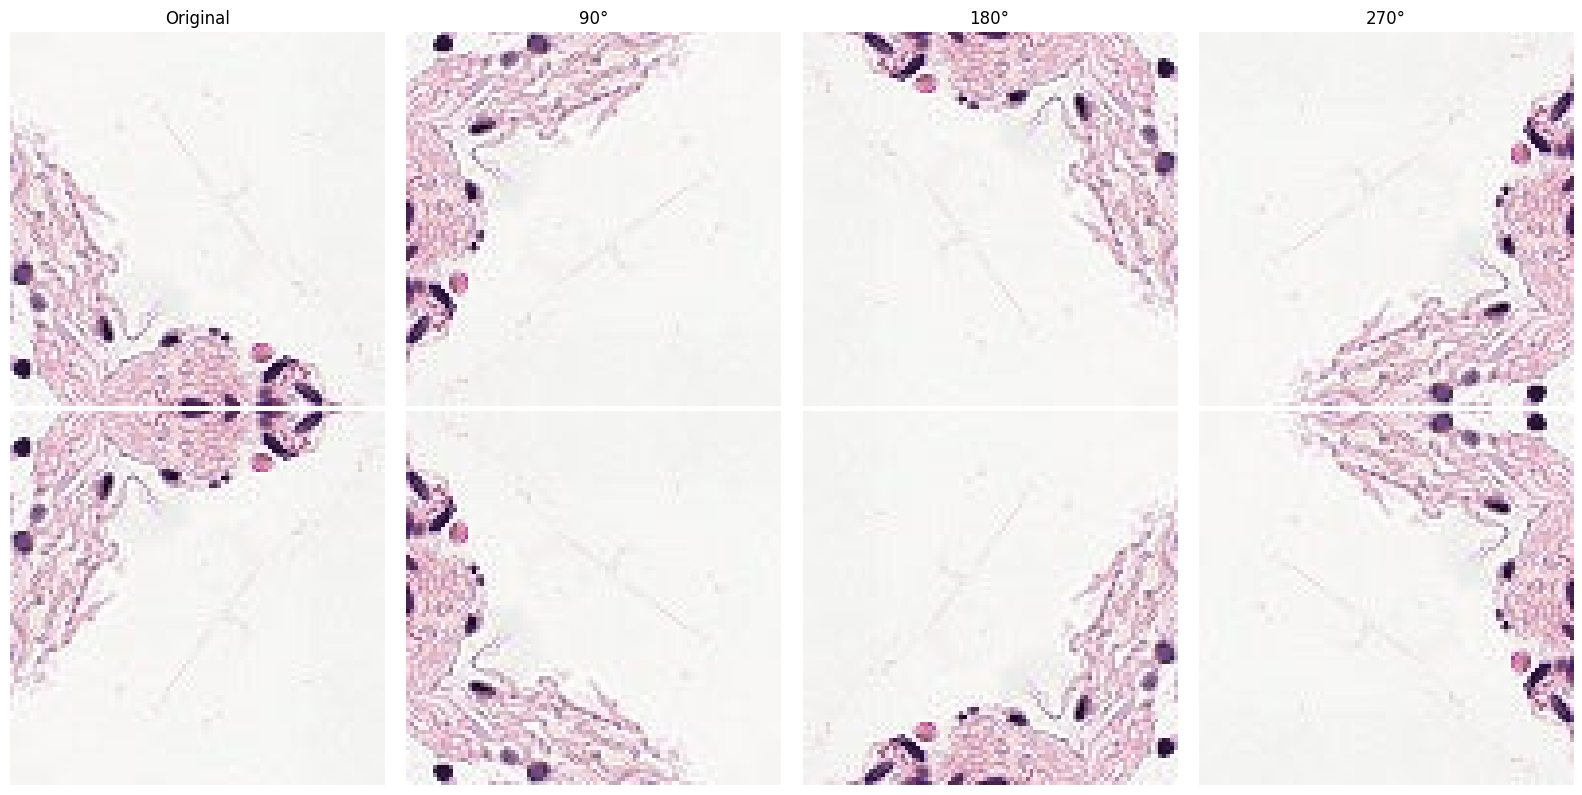

In [104]:
def get_transforms(image, n_rotations=4, flips=True):
    """
    Returns all transformations of a single input image
    """
    transforms = [image]

    # Rotations
    for i in range(1, n_rotations):
        angle = i * (360 / n_rotations)
        rotated_image = TF.rotate(image, angle)
        transforms.append(rotated_image)

    # Flips
    if flips:
        flips = []
        for transform in transforms:
            flipped_image_lr = TF.hflip(transform)
            flips.append(flipped_image_lr)
        # for transform in transforms:
        #     flipped_image_ud = TF.vflip(transform)
        #     flips.append(flipped_image_ud)
        transforms.extend(flips)
    res = torch.cat(transforms)
    return res

def visualize_transforms(transformed_images):
    num_images = len(transformed_images)
    num_rows = (num_images - 1) // 4 + 1
    fig, axes = plt.subplots(num_rows, 4, figsize=(16, 4*num_rows))

    for i, img in enumerate(transformed_images):
        row = i // 4
        col = i % 4
        if rotmnist:
            axes[row, col].imshow(img.permute(1, 2, 0), cmap="gray")  # Permute dimensions for visualization
        else:
            axes[row, col].imshow(img.transpose(0, -1))
        axes[row, col].axis('off')

    # Hide empty subplots
    for i in range(num_images, num_rows * 4):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')

    # Labeling axes
    for ax, col in zip(axes[0], ['Original', '90°', '180°', '270°']):
        ax.set_title(col, size="larger")

    plt.tight_layout()
    plt.show()

transformed_images = get_transforms(image)
visualize_transforms(transformed_images)

In [60]:
model.forward(image.to(device), output_cls=True).shape, model.forward(get_transforms(image.to(device)), output_cls=True).shape

(torch.Size([1, 64]), torch.Size([8, 64]))

#### Some possibilities of equivariant combination of the latent representations:
- Mean pooling
- Max pooling
- Sum
- Most probable
- Highest probability among transformations
- Learn weights for weighted average

In [61]:
from post_hoc_equivariant import *
from sub_models import ScoringModel, Transformer

#### First keeping the original model frozen

In [63]:
len(val_loader)

256

In [97]:
# baseline
evaluate(model)

100%|██████████| 2/2 [00:06<00:00,  3.06s/it]


66.87116564417178

In [101]:
# mean pooling
eq_model_mean = PostHocEquivariantMean(model, n_rotations=4, flips=True)
evaluate(eq_model_mean)

100%|██████████| 2/2 [02:10<00:00, 65.39s/it] 


47.239263803680984

In [ ]:
# max pooling
eq_model_max = PostHocEquivariantMax(model, n_rotations=16, flips=False)
evaluate(eq_model_max)

In [ ]:
# summing latent dimensions
eq_model_sum = PostHocEquivariantSum(model, n_rotations=16, flips=False)
evaluate(eq_model_sum)

In [105]:
# product of class probabilities
eq_model_most_probable = PostHocEquivariantMostProbable(model, n_rotations=4, flips=True)
evaluate(eq_model_most_probable)

100%|██████████| 2/2 [00:32<00:00, 16.37s/it]


68.09815950920246

In [106]:
# take transformation with highest certainty for class
eq_model_most_certain = PostHocMostCertain(model, n_rotations=4, flips=True)
evaluate(eq_model_most_certain)

100%|██████████| 2/2 [00:34<00:00, 17.36s/it]


66.87116564417178

#### Learn weighs for weighted average

Also here there are a couple of options.
- a) nn takes as input entire latent dimension and outputs scalar representing weight for that dimensions
- b) nn takes as input the i'th entry of each latent dimension, the concatenation is a new latent dimension. Now we have to satisfy equivariance so this order of input should not matter. Use a transformer without PE in this case is a solution.


In [ ]:
# a)
set_seed(42)
scoring_model = ScoringModel()
eq_model_learned_score_aggregation = PostHocLearnedScoreAggregation(model=model, scoring_model=scoring_model)
eq_model_learned_score_aggregation = train(eq_model_learned_score_aggregation, n_epochs=10)
evaluate(eq_model_learned_score_aggregation)

In [ ]:
# b)
set_seed(42)
aggregation_model = Transformer(embed_dim=64, hidden_dim=128, num_heads=4, num_layers=2, dropout=0.1)
eq_model_learned_aggregation = PostHocLearnedAggregation(model=model, aggregation_model=aggregation_model)
eq_model_learned_aggregation = train(eq_model_learned_aggregation, n_epochs=25)
evaluate(eq_model_learned_aggregation)

#### Now all options but with finetuning the mlp_head

In [ ]:
# mean pooling
set_seed(42)
model = get_non_equivariant_vit()
eq_model_mean = PostHocEquivariantMean(model, finetune_mlp_head=True)
eq_model_mean = train(eq_model_mean, n_epochs=25)
evaluate(eq_model_mean)

In [ ]:
# max pooling
set_seed(42)
model = get_non_equivariant_vit()
eq_model_max = PostHocEquivariantMax(model, finetune_mlp_head=True)
eq_model_max = train(eq_model_max, n_epochs=25)
evaluate(eq_model_max)

In [ ]:
# summing latent dimensions
set_seed(42)
model = get_non_equivariant_vit()
eq_model_sum = PostHocEquivariantSum(model, finetune_mlp_head=True)
eq_model_sum = train(eq_model_sum, n_epochs=25)
evaluate(eq_model_sum)

In [ ]:
# product of class probabilities
set_seed(42)
model = get_non_equivariant_vit()
eq_model_most_probable = PostHocEquivariantMostProbable(model, finetune_mlp_head=True)
eq_model_most_probable = train(eq_model_most_probable, n_epochs=25)
evaluate(eq_model_most_probable)

In [ ]:
# take transformation with highest certainty for class
set_seed(42)
model = get_non_equivariant_vit()
eq_model_most_certain = PostHocMostCertain(model, finetune_mlp_head=True)
eq_model_most_certain = train(eq_model_most_certain, n_epochs=25)
evaluate(eq_model_most_certain)

In [ ]:
# a)
set_seed(42)
model = get_non_equivariant_vit()
scoring_model = ScoringModel()
eq_model_learned_score_aggregation = PostHocLearnedScoreAggregation(model=model, scoring_model=scoring_model, finetune_mlp_head=True)
eq_model_learned_score_aggregation = train(eq_model_learned_score_aggregation, n_epochs=25)
evaluate(eq_model_learned_score_aggregation)

In [ ]:
# b)
set_seed(42)
aggregation_model = Transformer(embed_dim=64, hidden_dim=128, num_heads=4, num_layers=2, dropout=0.1)
eq_model_learned_aggregation = PostHocLearnedAggregation(model=model, aggregation_model=aggregation_model, finetune_mlp_head=True)
eq_model_learned_aggregation = train(eq_model_learned_aggregation, n_epochs=25)
evaluate(eq_model_learned_aggregation)

#### Now all options but finetuning the entire base model

In [ ]:
# mean pooling
set_seed(42)
model = get_non_equivariant_vit()
eq_model_mean = PostHocEquivariantMean(model, finetune_model=True)
eq_model_mean = train(eq_model_mean, n_epochs=25)
evaluate(eq_model_mean)

In [ ]:
# max pooling
set_seed(42)
model = get_non_equivariant_vit()
eq_model_max = PostHocEquivariantMax(model, finetune_model=True)
eq_model_max = train(eq_model_max, n_epochs=25)
evaluate(eq_model_max)

In [ ]:
# summing latent dimensions
set_seed(42)
model = get_non_equivariant_vit()
eq_model_sum = PostHocEquivariantSum(model, finetune_model=True)
eq_model_sum = train(eq_model_sum, n_epochs=25)
evaluate(eq_model_sum)

In [ ]:
# product of class probabilities
set_seed(42)
model = get_non_equivariant_vit()
eq_model_most_probable = PostHocEquivariantMostProbable(model, finetune_model=True)
eq_model_most_probable = train(eq_model_most_probable, n_epochs=25)
evaluate(eq_model_most_probable)

In [ ]:
# take transformation with highest certainty for class
set_seed(42)
model = get_non_equivariant_vit()
eq_model_most_certain = PostHocMostCertain(model, finetune_model=True)
eq_model_most_certain = train(eq_model_most_certain, n_epochs=25)
evaluate(eq_model_most_certain)

In [ ]:
# a)
set_seed(42)
model = get_non_equivariant_vit()
scoring_model = ScoringModel()
eq_model_learned_score_aggregation = PostHocLearnedScoreAggregation(model=model, scoring_model=scoring_model, finetune_model=True)
eq_model_learned_score_aggregation = train(eq_model_learned_score_aggregation, n_epochs=25)
evaluate(eq_model_learned_score_aggregation)

In [ ]:
# b)
set_seed(42)
aggregation_model = Transformer(embed_dim=64, hidden_dim=128, num_heads=4, num_layers=2, dropout=0.1)
eq_model_learned_aggregation = PostHocLearnedAggregation(model=model, aggregation_model=aggregation_model, finetune_model=True)
veq_model_learned_aggregation = train(eq_model_learned_aggregation, n_epochs=25)
evaluate(eq_model_learned_aggregation)